**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```

> Note: sometimes your answer doesn't match one of the options exactly. That's fine. 
Select the option that's closest to your solution.

In [2]:
!pip install xgboost

In [32]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

%matplotlib inline

## Loading the data
Use only the following columns:  
* `'latitude'`,
* `'longitude'`,
* `'housing_median_age'`,
* `'total_rooms'`,
* `'total_bedrooms'`,
* `'population'`,
* `'households'`,
* `'median_income'`,
* `'median_house_value'`,
* `'ocean_proximity'`  


* Fill NAs with 0.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer` to turn the dataframe into matrices.

In [42]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
#!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [44]:
#@ READING DATASET:
PATH = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [45]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [46]:
df.median_house_value = np.log1p(df.median_house_value)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [47]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [48]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [49]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [50]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [51]:
df_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,INLAND
1,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,INLAND
2,-118.26,33.78,27.0,1672.0,491.0,1723.0,462.0,2.0458,NEAR OCEAN
3,-117.33,34.17,5.0,4718.0,1140.0,2564.0,1056.0,2.9877,INLAND
4,-119.02,35.35,42.0,1239.0,251.0,776.0,272.0,1.9830,INLAND
...,...,...,...,...,...,...,...,...,...
12379,-118.19,34.06,32.0,555.0,159.0,748.0,163.0,1.9762,<1H OCEAN
12380,-122.30,37.90,37.0,2125.0,489.0,912.0,462.0,2.9219,NEAR BAY
12381,-118.36,33.90,18.0,3380.0,922.0,2276.0,854.0,4.0727,<1H OCEAN
12382,-119.79,36.78,41.0,2227.0,462.0,1129.0,415.0,2.3190,INLAND


- We will use `DictVectorizer` to turn train and validation into matrices.

In [52]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_train

array([[ 578.  ,   19.  ,   34.63, ..., 1677.  ,  606.  , 3562.  ],
       [  50.  ,   10.  ,   34.69, ...,  108.  ,  102.  ,  337.  ],
       [ 462.  ,   27.  ,   33.78, ..., 1723.  ,  491.  , 1672.  ],
       ...,
       [ 854.  ,   18.  ,   33.9 , ..., 2276.  ,  922.  , 3380.  ],
       [ 415.  ,   41.  ,   36.78, ..., 1129.  ,  462.  , 2227.  ],
       [ 589.  ,    9.  ,   34.02, ..., 2280.  ,  587.  , 4265.  ]])

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [53]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [54]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [87]:
#@ INSPECTION:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



Which feature is used for splitting the data?

* **`ocean_proximity=INLAND`**
* `total_rooms`
* `latitude`
* `population`

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)

In [57]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [62]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print('train:', rmse.round(2))

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print('val:', rmse.round(2))

train: 0.11
val: 0.25


What's the RMSE of this model on validation?

* 0.05
* **0.25**
* 0.55
* 0.85

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [68]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []
n_estimators = [*range(10, 201, 10)]

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n,
                               random_state=1,
                               n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, rmse))

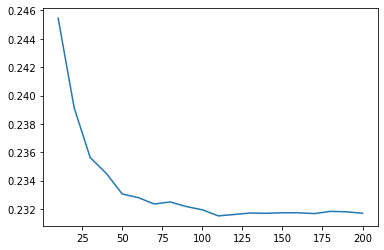

In [70]:
#@ INSPECTING THE RMSE SCORES:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- **150**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [71]:
#@ TRAINING THE MODEL WITH DEPTH:

scores = []
max_depth = [10, 15, 20, 25]
n_estimators = [*range(10, 201, 10)]

for d in max_depth:
    for n in n_estimators:
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, rmse))

In [72]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

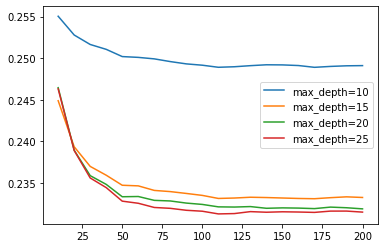

In [74]:
for d in max_depth:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

What's the best `max_depth`:

* 10
* 15
* 20
* **25**

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

In [75]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [78]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

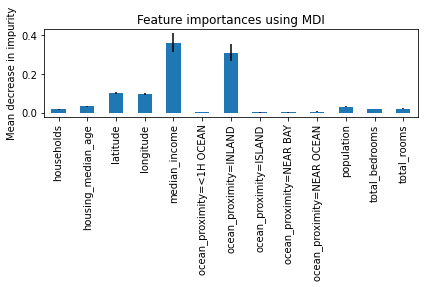

In [85]:
forest_importances = pd.Series(importances, index=dv.feature_names_)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

What's the most important feature? 

* `total_rooms`
* **`median_income`**
* `total_bedrooms`
* `longitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [88]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [96]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

- Now, change eta first to 0.1 and then to 0.01.

In [97]:
y_pred = model.predict(dval)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print('eta=0.3 rmse:', rmse.round(3))

eta=0.3 rmse: 0.226


In [98]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [99]:
y_pred = model.predict(dval)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print('eta=0.1 rmse:', rmse.round(3))

eta=0.1 rmse: 0.231


In [100]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [102]:
y_pred = model.predict(dval)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print('eta=0.01 rmse:', rmse.round(3))

eta=0.01 rmse: 4.265


Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* **0.3**
* 0.1
* Both gives same

## Submit the results

* Submit your results here: https://forms.gle/3yMSuQ4BeNuZFHTU8
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one


## Deadline

The deadline for submitting is 17 October (Monday), 23:00 CEST.

After that, the form will be closed.